<a href="https://colab.research.google.com/github/karma659/files/blob/main/projectGass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Suppress specific warnings from statsmodels
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

In [341]:
df= pd.read_csv('/content/sample_data/Nat_Gas.csv')
df.tail(5)

,Dates,Prices
43,5/31/24,11.4
44,6/30/24,11.5
45,7/31/24,11.6
46,8/31/24,11.5
47,9/30/24,11.8


In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


In [343]:
# Convert 'Dates' column to datetime format
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')

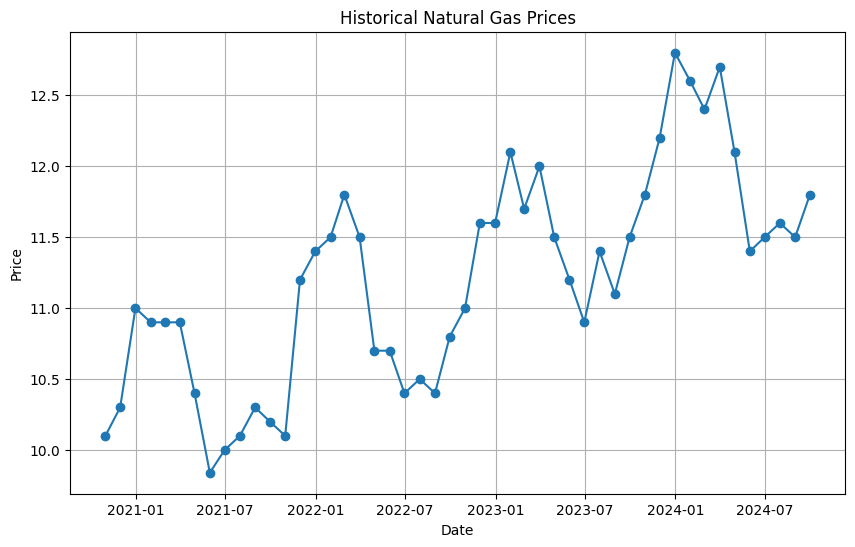

In [344]:
# Plotting the historical natural gas prices to observe trends
plt.figure(figsize=(10, 6))
plt.plot(df['Dates'], df['Prices'], marker='o', linestyle='-')
plt.title('Historical Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [345]:
df["sma3"]=df["Prices"].rolling(3).mean()
df["sma12"]=df["Prices"].rolling(12).mean()
df.tail(5)

,Dates,Prices,sma3,sma12
43,2024-05-31,11.4,12.066667,11.908333
44,2024-06-30,11.5,11.666667,11.958333
45,2024-07-31,11.6,11.500000,11.975000
46,2024-08-31,11.5,11.533333,12.008333
47,2024-09-30,11.8,11.633333,12.033333


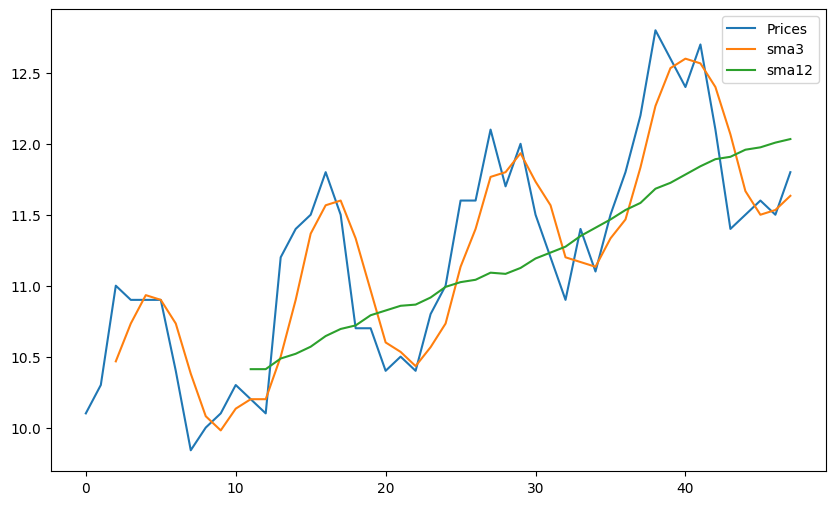

In [346]:
df.loc[:,["Prices","sma3","sma12"]].plot(figsize=(10,6));

In [347]:
df.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [348]:

# Fit a linear regression line using np.polyfit
reg = np.polyfit(df.index.values, df["Prices"], deg = 1)
reg

array([ 0.03901324, 10.29027211])

In [349]:
# Calculate trend line values using the regression coefficients
trend = np.polyval(reg, df.index.values)
# Calculate standard deviation of Prices
std = df['Prices'].std()

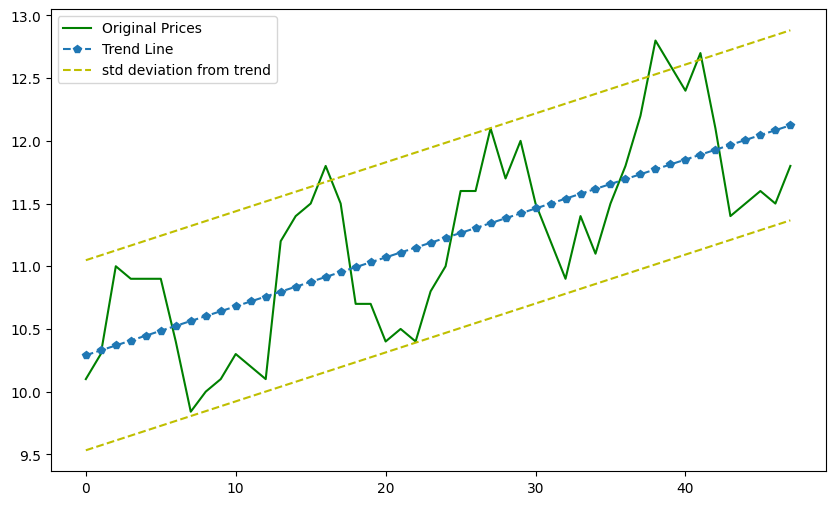

In [350]:
plt.figure(figsize=(10, 6))
plt.plot(df.index.values, df['Prices'], label='Original Prices', color='green')
plt.plot(df.index.values, trend, 'p--', label='Trend Line');
plt.plot(df.index.values, trend - std, 'y--',label='std deviation from trend')
plt.plot(df.index.values, trend + std, 'y--')
plt.legend(loc="upper left", fontsize=10);

In [351]:
#Forecasting using SARIMA

In [352]:
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

In [353]:
model = SARIMAX(df['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model = model.fit()

In [354]:
# Last date and price from historical data
last_date = df.index[-1]
last_price = df['Prices'].iloc[-1]

# Extend the forecast index to start from the last historical date
forecast_index = pd.date_range(start=last_date, periods=13, freq='ME')  # 12 future points + last point

# Add the last price as the first value in forecast_values to ensure continuity
forecast_values_with_last = pd.Series([last_price] + forecast.predicted_mean.tolist(), index=forecast_index)

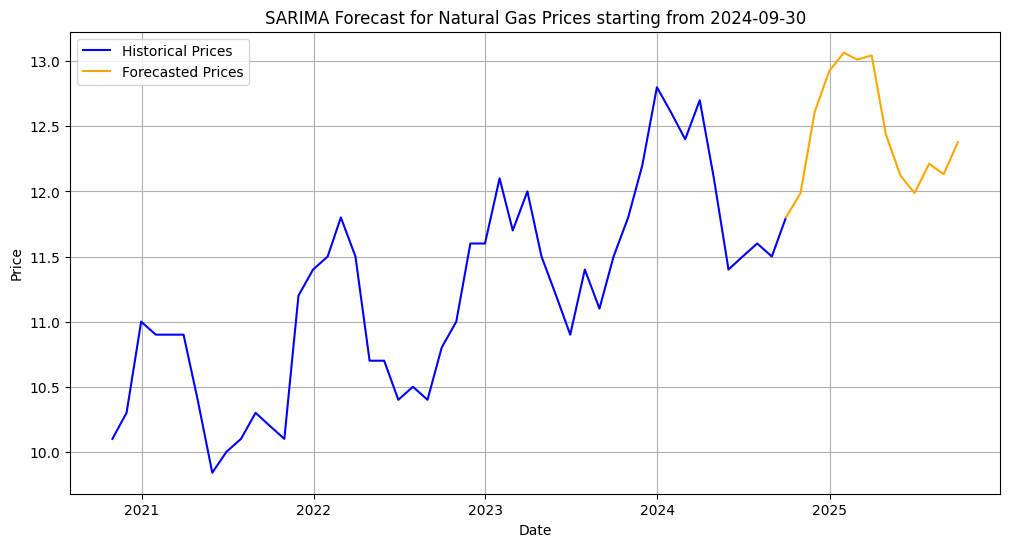

In [355]:
# Plot historical and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(df['Prices'], label='Historical Prices', color='blue')
plt.plot(forecast_index, forecast_values_with_last, label='Forecasted Prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SARIMA Forecast for Natural Gas Prices starting from 2024-09-30')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()


In [357]:
# Estimated price for any date

p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Fit the SARIMA model on the normal time series
sarima_model = SARIMAX(df['Prices'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

# Fit a SARIMA model on the reversed (backward) time series for backcasting
df_reversed = df[::-1].copy()
backcast_model = SARIMAX(df_reversed['Prices'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

def get_price_estimate(date_str):
    """
    Returns the estimated price for a given date (past, present, or future) using SARIMA models.

    Parameters:
    date_str (str): The date for which to estimate the price, in 'YYYY-MM-DD' format.

    Returns:
    float: Estimated price for the given date.
    """
    # Convert input date string to a datetime object
    target_date = pd.to_datetime(date_str)

    # Determine if the date is before, within, or after the dataset range
    if target_date < df.index[0]:
        # BACKCAST: Target date is before the start of historical data
        # Calculate the number of months from the end of the dataset to the target date
        months_behind = (df.index[0].year - target_date.year) * 12 + (df.index[0].month - target_date.month)

        # Generate backcast forecast for the required months behind
        backcast = backcast_model.get_forecast(steps=months_behind)
        backcast_values = backcast.predicted_mean

        # Create backcast index starting from the last date of the reversed series
        backcast_index = pd.date_range(end=df.index[0], periods=months_behind, freq='ME')[::-1]
        backcast_series = pd.Series(backcast_values.values, index=backcast_index)

        # # Plotting
        # plt.figure(figsize=(10, 6))
        # plt.plot(df['Prices'], label='Historical Prices', color='blue')
        # plt.plot(backcast_series, label='Backcasted Prices', color='green', linestyle='--')
        # plt.xlabel('Date')
        # plt.ylabel('Price')
        # plt.title('Backcasted and Historical Natural Gas Prices')
        # plt.legend()
        # plt.grid(True)
        # plt.show()


        # Return the backcasted price for the specific target date
        return backcast_series.loc[target_date] if target_date in backcast_series.index else backcast_series.iloc[-1]

    elif target_date > df.index[-1]:
        # FORECAST: Target date is in the future
        months_ahead = (target_date.year - df.index[-1].year) * 12 + (target_date.month - df.index[-1].month)

        forecast = sarima_model.get_forecast(steps=months_ahead)
        forecast_values = forecast.predicted_mean
        forecast_index = pd.date_range(start=df.index[-1], periods=months_ahead, freq='ME')
        forecast_series = pd.Series(forecast_values.values, index=forecast_index)

        # # Plotting
        # plt.figure(figsize=(10, 6))
        # plt.plot(df['Prices'], label='Historical Prices', color='blue')
        # plt.plot(forecast_series, label='Forecasted Prices', color='orange', linestyle='--')
        # plt.xlabel('Date')
        # plt.ylabel('Price')
        # plt.title('Historical and Forecasted Natural Gas Prices')
        # plt.legend()
        # plt.grid(True)
        # plt.show()

        # Return the forecasted price for the target date
        return forecast_series.loc[target_date] if target_date in forecast_series.index else forecast_series.iloc[-1]

    else:
        # PRESENT: Target date is within the historical range
        all_dates = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')

        # Reindex the DataFrame to include all dates in the range
        df_all_dates = df.reindex(all_dates)

        # Interpolate to fill in missing values
        df_all_dates['Prices'] = df_all_dates['Prices'].interpolate(method='linear')

        # Return the forecasted price for the target date
        return df_all_dates.loc[target_date, 'Prices']


date_to_check = "2025-02-21"
price_estimate = get_price_estimate(date_to_check)
print(f"Estimated price for {date_to_check}: {price_estimate}");


Estimated price for 2025-02-21: 13.01229825910038


In [358]:
#TASK 2

def calculate_contract_value(injection_dates, withdrawal_dates, prices,
                             injection_rate, withdrawal_rate,
                             max_storage_volume, storage_cost_per_unit):
    """
    Calculates the value of a gas storage contract based on specified parameters.

    Parameters:
    - injection_dates (list of str): Dates to inject gas (YYYY-MM-DD format).
    - withdrawal_dates (list of str): Dates to withdraw gas (YYYY-MM-DD format).
    - prices (dict): A dictionary of dates (str) and corresponding prices (float).
    - injection_rate (float): The rate at which gas can be injected (units per day).
    - withdrawal_rate (float): The rate at which gas can be withdrawn (units per day).
    - max_storage_volume (float): The maximum volume that can be stored.
    - storage_cost_per_unit (float): Storage cost per unit per day.

    Returns:
    - float: Net value of the contract.
    """

    # Initialize storage volume and cash flow trackers
    storage_volume = 0
    total_revenue = 0.0
    total_cost = 0.0
    total_storage_cost = 0.0

    # Convert dates to datetime for easier manipulation
    injection_dates = pd.to_datetime(injection_dates)
    withdrawal_dates = pd.to_datetime(withdrawal_dates)

    # Sort dates to calculate storage costs day by day in chronological order
    all_dates = sorted(set(injection_dates).union(set(withdrawal_dates)))

    for date in all_dates:
        date_str = date.strftime('%Y-%m-%d')

        # Injection phase
        if date in injection_dates:
            # Calculate volume to inject
            inject_volume = min(injection_rate, max_storage_volume - storage_volume)
            purchase_cost = inject_volume * prices[date_str]
            total_cost += purchase_cost
            storage_volume += inject_volume
            print(f"Injected {inject_volume} units at {prices[date_str]} on {date_str}, cost: {purchase_cost}")

        # Withdrawal phase
        if date in withdrawal_dates:
            # Calculate volume to withdraw
            withdraw_volume = min(withdrawal_rate, storage_volume)
            sales_revenue = withdraw_volume * prices[date_str]
            total_revenue += sales_revenue
            storage_volume -= withdraw_volume
            print(f"Withdrew {withdraw_volume} units at {prices[date_str]} on {date_str}, revenue: {sales_revenue}")

        # Storage cost for the current day based on current storage volume
        daily_storage_cost = storage_volume * storage_cost_per_unit
        total_storage_cost += daily_storage_cost
        print(f"Storage cost on {date_str}: {daily_storage_cost}")

    # Net value of the contract: revenue - costs - storage costs
    contract_value = total_revenue - total_cost - total_storage_cost
    print(f"Total revenue: {total_revenue}, Total cost: {total_cost}, Total storage cost: {total_storage_cost}")

    return contract_value

# Test the function with sample inputs
injection_dates = ["2023-01-01", "2023-01-05"]
withdrawal_dates = ["2023-01-15", "2023-01-20"]
# Populate prices dictionary for both injection and withdrawal dates
for date in injection_dates + withdrawal_dates:
    price_estimate = get_price_estimate(date)
    if isinstance(price_estimate, (int, float)):  # Ensure the price is valid (not an error message)
        prices[date] = price_estimate
    else:
        print(f"Error retrieving price for {date}: {price_estimate}")

# Output the filled prices dictionary
print("Prices dictionary:", prices)

Prices dictionary: {'2023-01-01': 11.616129032258064, '2023-01-05': 11.680645161290322, '2023-01-10': 11.761290322580646, '2023-01-15': 11.841935483870968, '2023-01-20': 11.92258064516129}


In [359]:
injection_rate = 100  # units per day
withdrawal_rate = 100  # units per day
max_storage_volume = 500  # maximum storage capacity
storage_cost_per_unit = 0.01  # storage cost per unit per day

contract_value = calculate_contract_value(injection_dates, withdrawal_dates, prices,
                                          injection_rate, withdrawal_rate,
                                          max_storage_volume, storage_cost_per_unit)
print(f"Contract Value: {contract_value}")

Injected 100 units at 11.616129032258064 on 2023-01-01, cost: 1161.6129032258063
Storage cost on 2023-01-01: 1.0
Injected 100 units at 11.680645161290322 on 2023-01-05, cost: 1168.0645161290322
Storage cost on 2023-01-05: 2.0
Withdrew 100 units at 11.841935483870968 on 2023-01-15, revenue: 1184.1935483870968
Storage cost on 2023-01-15: 1.0
Withdrew 100 units at 11.92258064516129 on 2023-01-20, revenue: 1192.258064516129
Storage cost on 2023-01-20: 0.0
Total revenue: 2376.451612903226, Total cost: 2329.6774193548385, Total storage cost: 4.0
Contract Value: 42.7741935483873
